# 需要实现的部分  
1、迭代器的构造  
2、lstm类的构造  
3、训练和测试函数的编写  

In [292]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pandas as pd
import torch
import akshare as ak
import numpy as np
import matplotlib.pyplot as plt
import random

导入数据

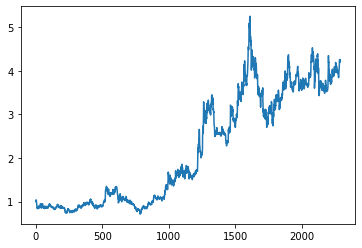

In [312]:
data = ak.stock_zh_a_daily(symbol="sz000002", start_date="20101103", end_date="20201116", adjust="hfq").iloc[:, 1:]
data = data / 1000
plt.plot(data.open)


迭代器的构造

In [313]:
def data_loader(data, batch_size, seq_len):
    # 通过初始裁剪以保证每次迭代的序列具有一定差异
    data = data[random.randint(0, seq_len):]
    # 计算序列数量
    num_seq = (len(data)-1) // seq_len
    # 计算batch数量
    num_batch  =num_seq // batch_size
    
    # 计算初始点位置
    init_indexs = list(range(0, num_seq*seq_len, seq_len))
    random.shuffle(init_indexs)
    
    def _data(index):
        return data[index:index+seq_len]
    
    for i in range(0, batch_size*num_batch, batch_size):
        indexs = init_indexs[i:i+batch_size]
        X = [_data(j) for j in indexs]
        Y = [_data(j+1) for j in indexs]
        yield torch.tensor(X).reshape((batch_size, seq_len, 1)), torch.tensor(Y).reshape((batch_size, seq_len, 1))

In [314]:
class DataLoader:
    def __init__(self, data, batch_size, seq_len, iter_fn):
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.data = data
        self.iter_fn = iter_fn
        
    def __iter__(self):
        # 注意data应该是ndarray或者list类型
        return self.iter_fn(self.data, self.batch_size, self.seq_len)

LSTM类实现

In [393]:
def get_param(input_dim, output_dim, hidden_size):
    # 有几个门
    #遗忘门、输入门、输出门、候选记忆
    def normal(shape):
        return torch.randn(size=shape)
    
    # 返回
    def three():
        return (normal((input_dim, hidden_size)),
               normal((hidden_size, hidden_size)),
               torch.zeros(hidden_size))
    
    w_ix, w_ih, b_i = three()
    w_fx, w_fh, b_f = three()
    w_cx, w_ch, b_c = three()
    w_ox, w_oh, b_o = three()
    
    # 输出层参数
    w_hq = normal((hidden_size, output_dim))
    b_q = torch.zeros(output_dim)
    
    params = [w_ix, w_ih, b_i, w_fx, w_fh, b_f, 
              w_cx, w_ch, b_c,  w_ox, w_oh, b_o, w_hq, b_q]
    
    for param in params:
        param.requires_grad_(True)
        
    return params

In [394]:
def lstm(X, state, params):
    # 获取各个参数
    w_ix, w_ih, b_i, w_fx, w_fh, b_f, w_cx, w_ch, b_c,  w_ox, w_oh, b_o, w_hq, b_q = params
    
    # 获取隐状态和记忆单元
    H, C = state
    
    # 将输入转化成batch_first=Fasle的形式
    X = X.permute(1, 0, 2)
    outputs = []
    for x in X:
        F = torch.sigmoid(torch.matmul(x, w_fx) + torch.matmul(H, w_fh) + b_f)
        I = torch.sigmoid(torch.matmul(x, w_ix) + torch.matmul(H, w_ih) + b_i)
        C_tilda = torch.tanh(torch.matmul(x, w_cx) + torch.matmul(H, w_ch) + b_c)
        C = C * F + C_tilda * I
        O = torch.sigmoid(torch.matmul(x, w_ox) + torch.matmul(H, w_oh) + b_o)
        H = O * torch.tanh(C)
        outputs.append(torch.matmul(H, w_hq) + b_q)
    return torch.cat(outputs, dim=0).reshape((-1, X.shape[0], w_hq.shape[1])), (H, C)

In [395]:
def init_state(batch_size, hidden_dim):
    return (torch.zeros((batch_size, hidden_dim)), 
            torch.zeros((batch_size, hidden_dim)))

In [396]:
class MyLSTM:
    def __init__(self, input_dim, output_dim, hidden_dim, 
                 get_param, forward_fn, init_state):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.params = get_param(input_dim, output_dim, hidden_dim)
        self.forward_fn = forward_fn
        self.init_state = init_state
        
    def __call__(self, X, state):
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.hidden_dim)


测试一下输入输出

In [397]:
dl = DataLoader(data.open.values, 16, 20, data_loader)
net = MyLSTM(1, 1, 100, get_param, lstm, init_state)
for X, Y in dl:
    state = net.begin_state(16)
    X, Y = X.float(), Y.float()
    print(X.shape)
    print(Y.shape)
    O, state = net(X, state)
    print(O.shape)
    print(state[0].shape)
    print(state[1].shape)
    break

torch.Size([16, 20, 1])
torch.Size([16, 20, 1])
torch.Size([16, 20, 1])
torch.Size([16, 100])
torch.Size([16, 100])


编写训练和预测函数

In [398]:
def train_epoch(dataloader, net, loss, updater, theta):
    # 需要的参数：数据迭代器、损失函数、参数更新函数，学习率，网络,batchsize
    total_loss = 0
    for X, Y in dataloader:
        X, Y = X.float(), Y.float()
        # 设置隐含状态和记忆单元
        state = net.begin_state(dataloader.batch_size)
        y_hat, state = net(X, state)
        y_hat = y_hat.reshape(-1).float()
        Y = Y.reshape(-1).float()
        l = loss(y_hat, Y).mean()
        total_loss += l
        l.backward()
        grad_clipping(net, theta)
        updater(0)
    return total_loss

In [399]:
def grad_clipping(net, theta):
    params = net.params
    norm = torch.sqrt(sum(torch.sum(p.grad**2) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] = param.grad / norm

In [400]:
def backward_fn(params, lr):
    with torch.no_grad():
        for param in params:
            param[:] = param - lr * param.grad
            param.grad.zero_()

In [401]:
def train(dataloader, net, lr, epoches, backward_fn, theta):
    loss = torch.nn.MSELoss()
    updater = lambda x: backward_fn(net.params, lr)
    for epoch in range(epoches):
        total_loss = train_epoch(dataloader, net, loss, updater, theta)
        if (epoch+1) % 10 == 0:
            print(f"第{epoch+1}次训练， LOSS: ", total_loss)

In [409]:
net = MyLSTM(1, 1, 10, get_param, lstm, init_state)
dl = DataLoader(data.open.values, 16, 20, data_loader)
train(dl, net, 0.01, 500, backward_fn, 1)

第10次训练， LOSS:  tensor(59.6768, grad_fn=<AddBackward0>)
第20次训练， LOSS:  tensor(24.5480, grad_fn=<AddBackward0>)
第30次训练， LOSS:  tensor(12.6421, grad_fn=<AddBackward0>)
第40次训练， LOSS:  tensor(11.9277, grad_fn=<AddBackward0>)
第50次训练， LOSS:  tensor(11.0753, grad_fn=<AddBackward0>)
第60次训练， LOSS:  tensor(10.9940, grad_fn=<AddBackward0>)
第70次训练， LOSS:  tensor(11.2126, grad_fn=<AddBackward0>)
第80次训练， LOSS:  tensor(11.3840, grad_fn=<AddBackward0>)
第90次训练， LOSS:  tensor(11.3547, grad_fn=<AddBackward0>)
第100次训练， LOSS:  tensor(11.3840, grad_fn=<AddBackward0>)
第110次训练， LOSS:  tensor(11.3337, grad_fn=<AddBackward0>)
第120次训练， LOSS:  tensor(11.2365, grad_fn=<AddBackward0>)
第130次训练， LOSS:  tensor(11.2598, grad_fn=<AddBackward0>)
第140次训练， LOSS:  tensor(11.2105, grad_fn=<AddBackward0>)
第150次训练， LOSS:  tensor(11.4030, grad_fn=<AddBackward0>)
第160次训练， LOSS:  tensor(11.3489, grad_fn=<AddBackward0>)
第170次训练， LOSS:  tensor(11.1254, grad_fn=<AddBackward0>)
第180次训练， LOSS:  tensor(11.1976, grad_fn=<AddBackward0>)
第

检测

In [410]:
def test_iter(seq, batch_size, seq_len):
    num_seq = (len(seq)-seq_len-1) # 总的子序列数量
    num_batch = num_seq // batch_size
    init_indexs = list(range(0, num_batch*batch_size*seq_len-seq_len))
    def _data(index):
        return seq[index:index+seq_len]
    for i in range(0, num_batch*batch_size, batch_size):
        indices = init_indexs[i:i+batch_size]
        X = [_data(j) for j  in indices]
        Y = [_data(j+1) for j in indices]
        yield torch.tensor(X).reshape((batch_size, seq_len, -1)), torch.tensor(Y).reshape((batch_size, seq_len, -1))

In [411]:
def test(net, dataloader):
    preds = []
    correct = []
    for X, Y in dataloader:
        X, Y = X.float(), Y.float()
        state = net.begin_state(1)
        y_hat, state = net(X, state)
        preds.append(y_hat[0][-1][0].detach())
        correct.append(Y[0][-1][0].detach())
    return preds, correct

In [412]:
test_dl = DataLoader(data.open.values, 1, 20, test_iter)
preds, correct = test(net, test_dl)

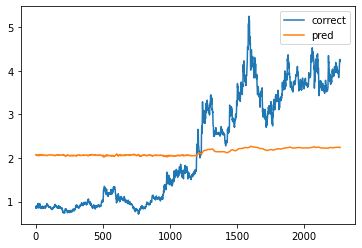

In [413]:
plt.plot(correct)
plt.plot(preds)
plt.legend(["correct", "pred"])

In [330]:
# preds_cum = (pd.DataFrame(preds) + 1).cumprod()
# correct_cum = (pd.DataFrame(correct) + 1).cumprod()
# plt.plot(correct_cum)
# plt.plot(preds_cum)
# plt.legend(["correct", "pred"])

使用Pytorch封装好的工具搭建LSTM

In [96]:
class MyLSTM2(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, 1, batch_first=True)
        self.linear = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, X, state):
        H, C = state
        X = X.permute(1, 0, 2)
        Y_hat, State = self.lstm(X, (H, C))
        Y_hat = Y_hat.permute(1, 0, 2)
        outputs = []
        for y_hat in Y_hat:
            outputs.append(self.linear(y_hat))
        outputs = torch.cat(outputs, dim=1)
        return outputs, state

In [105]:
net = MyLSTM2(1, 1, 60)
trainer = torch.optim.Adam(net.parameters(), lr=0.001)
loss = torch.nn.MSELoss()
epoches = 500

In [106]:
def train(net, trainer, epoches):
    for epoch in range(epoches):
        total_loss = 0
        for X, Y in dl:
            trainer.zero_grad()
            X, Y = X.float(), Y.reshape(-1).float()
            h0 = torch.randn((1, 5, 60))
            c0 = torch.randn((1, 5, 60))
            y_hat, state = net(X, (h0, c0))
            y_hat = y_hat.reshape(-1).float()
            l = loss(Y, y_hat)
            l.backward()
            total_loss += l
            trainer.step()
        if (epoch + 1) % 50 == 0:
            print(f"第{epoch+1}次训练，损失为：", total_loss)        

In [107]:
train(net, trainer, epoches)

第50次训练，损失为： tensor(56525124., grad_fn=<AddBackward0>)
第100次训练，损失为： tensor(56413660., grad_fn=<AddBackward0>)
第150次训练，损失为： tensor(56370612., grad_fn=<AddBackward0>)
第200次训练，损失为： tensor(55192044., grad_fn=<AddBackward0>)
第250次训练，损失为： tensor(54915120., grad_fn=<AddBackward0>)


KeyboardInterrupt: 